In [136]:
import numpy as np
import pandas as pd
import opendatasets as od
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold
)
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text, plot_tree
from sklearn.metrics import roc_curve, auc

from bank_chunk_data_processing import *
from classifiers import * 
from util import *

In [ ]:
"""import importlib
import bank_chunk_data_processing as m
importlib.reload(m)"""

<module 'bank_chunk_data_processing' from '/Users/yurkevychann/Downloads/ML course/Decision Trees/bank_chunk_data_processing.py'>

# Planning

In [2]:
""" pipeline
1. Split the training dataset into: train, validation (stratified)
2. Define target variable, define input features (features - based on obvious terms: IDs, Surnames )
--Cleaning--
3. Handling missing values: IQR, delete feature if missing values too much.
4. Encoding categorical variables.
5. Outlier detection.
6. Scaling: MinMaxScaler(), StandardScaler()
7. Handle class imbalance -> write function for class imbalance: class weights, resampling.
8.  Do the final feature selection: PCA, forward selection. Make conclusion why not include/include features.
9. Train the model on training data.
10. Evalute the performance on validation based on the model from training set.
11. Tune the parameters: regularization, different set of features.
12. Select the final model, train the final model on training data
13. Evaluate the performance on the test data (the remaining 20%)
"""

' pipeline\n1. Split the training dataset into: train, validation (stratified)\n2. Define target variable, define input features (features - based on obvious terms: IDs, Surnames )\n--Cleaning--\n3. Handling missing values: IQR, delete feature if missing values too much.\n4. Encoding categorical variables.\n5. Outlier detection.\n6. Scaling: MinMaxScaler(), StandardScaler()\n7. Handle class imbalance -> write function for class imbalance: class weights, resampling.\n8.  Do the final feature selection: PCA, forward selection. Make conclusion why not include/include features.\n9. Train the model on training data.\n10. Evalute the performance on validation based on the model from training set.\n11. Tune the parameters: regularization, different set of features.\n12. Select the final model, train the final model on training data\n13. Evaluate the performance on the test data (the remaining 20%)\n'

In [3]:
""" FUNCTIONS
1. Nan definition
2. Null definition.
3. Based on percentage of missing values, either delete or leave the column.
4. Scaling.
5. Splitting into train/test/validation. - done
6. Splitting using  CV. - also try to write different CVs.(Stratified K-fold cv, k-fold cv, bootstrapping)
7. Class imbalance: resampling.
8. Evaluation metrics.
"""

' FUNCTIONS\n1. Nan definition\n2. Null definition.\n3. Based on percentage of missing values, either delete or leave the column.\n4. Scaling.\n5. Splitting into train/test/validation. - done\n6. Splitting using  CV. - also try to write different CVs.(Stratified K-fold cv, k-fold cv, bootstrapping)\n7. Class imbalance: resampling.\n8. Evaluation metrics.\n'

In [4]:
od.version()

'0.1.22'

# MAIN

**Завдання 1.**
Ваше завдання зараз - перенести попередню обробку сирих даних з вашого розв'язку ДЗ 2.7 у файл `bank_chunk_data_processing.py` в функцію `preprocess_data(...)`.

Функція `preprocess_data()` має приймати `train_raw_df` і вертати `X_train`, `train_targets`, `X_val`, `val_targets`, `input_cols`(перелік назв колонок, які Ви використовуєте в X), `scaler`, `encoder`, які ми потім будемо використовувати для тренування дерева прийняття рішень.

## В результаті цього завдання

1. Завантажте ваш готовий `process_bank_churn.py` файл на GitHub у свій репозиторій.
2. Додайте посилання на файл в репозиторії тут у ноутбуці.
3. Нижче зробіть імпорт функції `preprocess_data` з вашого модуля `process_bank_churn.py`.

In [ ]:
# --FOR GOOGLE COLAB--
# connect to kaggle and get datasets: train.csv, test.csv
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-4'
data_dir = './bank-customer-churn-prediction-dlu-course-c-4'

In [ ]:
od.download(dataset_url)

In [ ]:
os.listdir(data_dir)

In [ ]:
train_csv = data_dir + '/train.csv'
test_csv = data_dir + '/test.csv'
train_raw_df = pd.read_csv(train_csv)
train_raw_df.head()

In [ ]:
test_csv = pd.read_csv(test_csv)
test_csv.head()

In [138]:
# --FOR VSCODE--: just downloaded and loaded files
train_raw_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [99]:
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [154]:
# call preprocess_data(train_raw_df: pd.DataFrame) function

X_train, y_train, X_validation, y_validation, scaler, encoder, input_features = m.preprocess_data(train_raw_df)


In [155]:
print(type(scaler))
print(type(encoder))

<class 'sklearn.preprocessing._data.MinMaxScaler'>
<class 'sklearn.preprocessing._encoders.OneHotEncoder'>


In [101]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.599045,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.603819,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.653938,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.568019,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.658711,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


In [102]:
y_train.head() # first column = ids, second: 0 | 1

7180     0.0
10393    0.0
80       0.0
3365     0.0
12236    0.0
Name: Exited, dtype: float64

In [103]:
input_features

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_France',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Female',
 'Gender_Male']

**Завдання 2.**
1. Натренуйте дерево прийняття рішень з зафіксованим `random_state` і з рештою аргументів за замовченням.
2. Виведіть area under ROC для моделі на тренувальних і тестувальних даних. Нам потрібна ця метрика, бо вона основна в змаганні. Модель ок, чи є пере- або недотренування?
3. Виведіть глибину дерева.
4. Побудуйте дерево до глибини 2 включно. Напишіть, які ознаки бачите, що є найвпливовішими тут?
5. Створіть датафрейм `importance_df` з feature importances, де в першому стовпчику `feature` - назва ознаки з нашого Х, а в другому `importance` - значення, наскільки ця ознака є важливою в побудованій моделі. Виведіть топ 10 найвпливовіших ознак разом з їх скором важливості (можна або у вигляді таблиці, або в вигляді barplot).

In [104]:
base_model = base_decision_tree_model(X_train, y_train) # refer to classifiers.py

AUROC for Validation: 0.7672


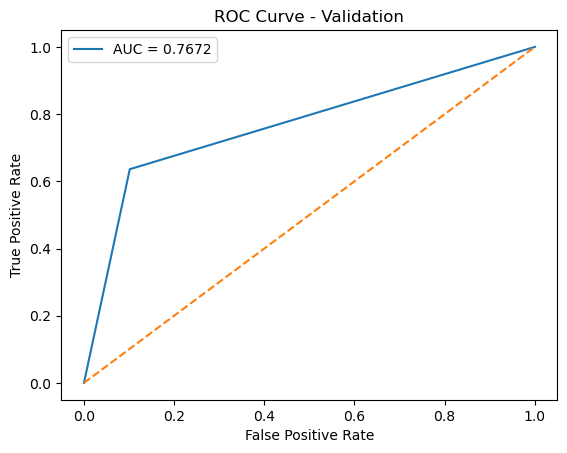

0.767195966801564

In [105]:
# Завдання 2: 2. Виведіть AUC ROC for the base model for training and test data(validation?)
compute_auroc_and_build_roc(
    base_model,
    X_validation,
    y_validation,
    name="Validation"
)

AUROC for Training: 1.0000


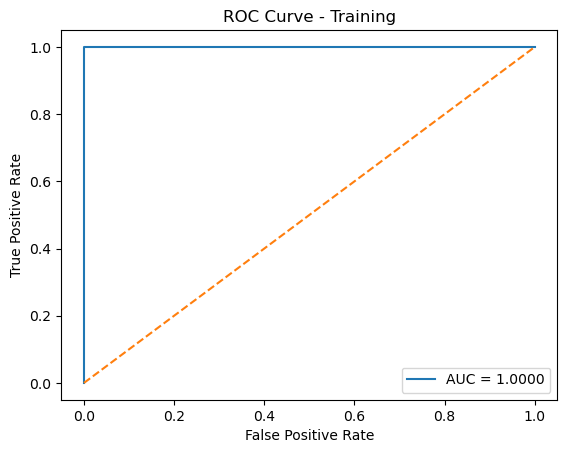

1.0

In [106]:
compute_auroc_and_build_roc(
    base_model,
    X_train,
    y_train,
    name="Training"
)


In [ ]:
"""
AUC ROC plot for training data shows signs of overfitting.
P.S. later I found out that the reason for overfitting a tree was absence of limitation on max_depth.
"""

In [107]:
train_preds = base_model.predict(X_train)

In [108]:
pd.value_counts(train_preds)

/var/folders/kn/4_3vhb9n3zl5fbqcd4r9lkw00000gn/T/ipykernel_79861/1258350197.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_preds)


0.0    9558
1.0    2442
Name: count, dtype: int64

In [109]:
base_model.score(X_validation, y_validation)

0.845

In [110]:
y_pred = base_model.predict(X_validation) 

In [111]:
# Завдання 2: 3. Max depth of the tree
print("Max depth of the tree: ", base_model.tree_.max_depth)

Max depth of the tree:  29


In [ ]:
# Завдання 2: 4. Побудуйте дерево до глибини 2 включно. Напишіть, які ознаки бачите, що є найвпливовішими тут?

In [112]:
limited_tree_depth_model = limited_tree_depth_model(X_train, y_train)

In [113]:
limited_tree_depth_model

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",2
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [18]:
tree_text = export_text(base_model, max_depth=2, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Age <= 0.38
|   |--- NumOfProducts <= 0.17
|   |   |--- Geography_Germany <= 0.50
|   |   |   |--- truncated branch of depth 27
|   |   |--- Geography_Germany >  0.50
|   |   |   |--- truncated branch of depth 18
|   |--- NumOfProducts >  0.17
|   |   |--- NumOfProducts <= 0.50
|   |   |   |--- truncated branch of depth 20
|   |   |--- NumOfProducts >  0.50
|   |   |   |--- truncated branch of depth 6
|--- Age >  0.38
|   |--- NumOfProducts <= 0.17
|   |   |--- Age <= 0.46
|   |   |   |--- truncated branch of depth 21
|   |   |--- Age >  0.46
|   |   |   |--- truncated branch of depth 21
|   |--- NumOfProducts >  0.17
|   |   |--- NumOfProducts <= 0.50
|   |   |   |--- truncated branch of depth 23
|   |   |--- NumOfProducts >  0.50
|   |   |   |--- truncated branch of depth 4



In [114]:
tree_text = export_text(limited_tree_depth_model, max_depth=2, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Age <= 0.38
|   |--- NumOfProducts <= 0.17
|   |   |--- class: 0.0
|   |--- NumOfProducts >  0.17
|   |   |--- class: 0.0
|--- Age >  0.38
|   |--- NumOfProducts <= 0.17
|   |   |--- class: 1.0
|   |--- NumOfProducts >  0.17
|   |   |--- class: 0.0



In [ ]:
"""
# Important features:
- AGE
- NumOfProducts
"""

In [115]:
limited_tree_depth_model.feature_importances_.round(2)

array([0.  , 0.73, 0.  , 0.  , 0.27, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  ])

In [116]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': limited_tree_depth_model.feature_importances_
}).sort_values('importance', ascending=False)

In [117]:
importance_df.head(10)

,feature,importance
1,Age,0.726816
4,NumOfProducts,0.273184
0,CreditScore,0.000000
2,Tenure,0.000000
3,Balance,0.000000
5,HasCrCard,0.000000
6,IsActiveMember,0.000000
7,EstimatedSalary,0.000000
8,Geography_France,0.000000
9,Geography_Germany,0.000000


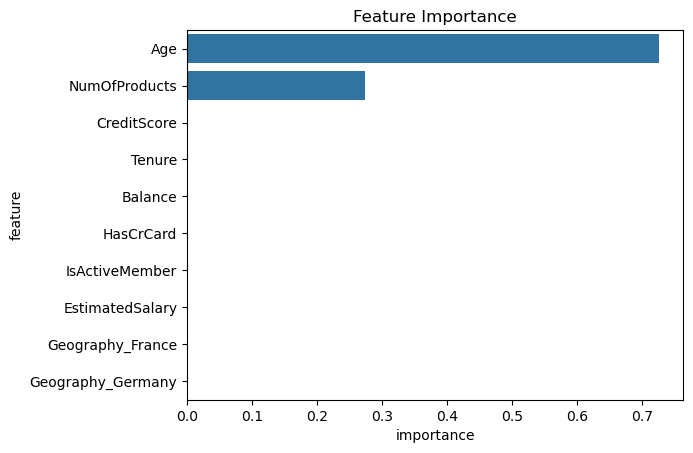

In [118]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

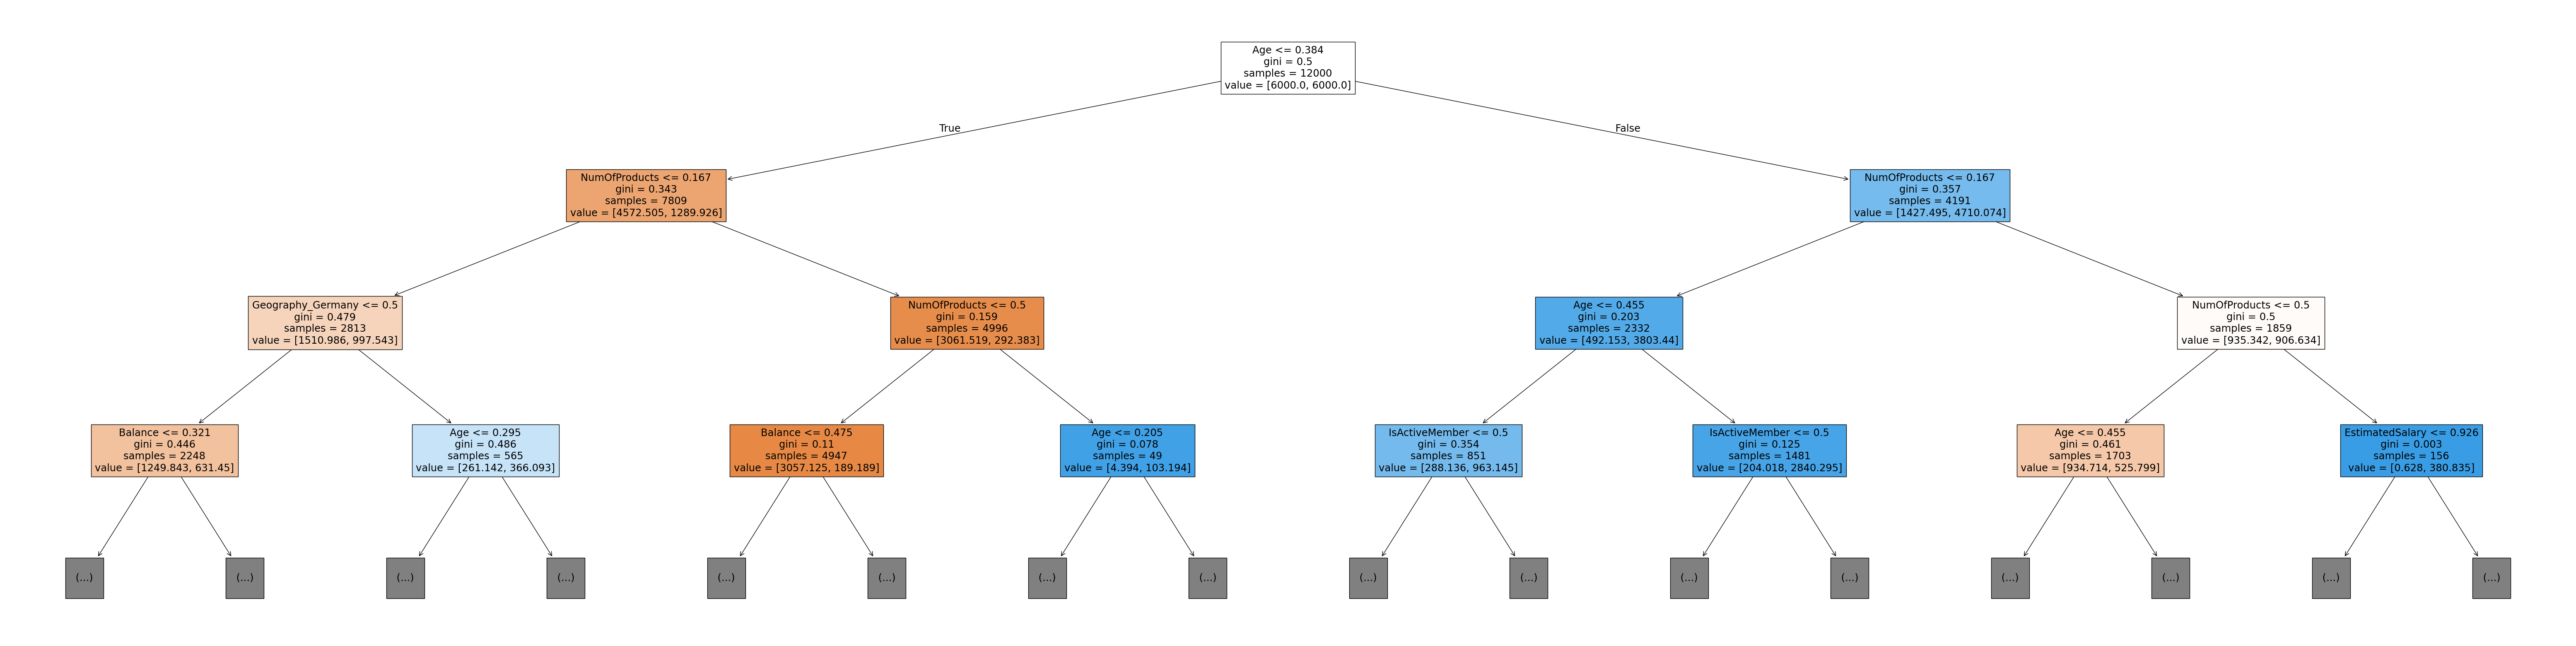

In [119]:
plt.figure(figsize=(80,20))
plot_tree(base_model, feature_names=X_train.columns, max_depth=3, filled=True);

AUROC for Validation: 0.8492


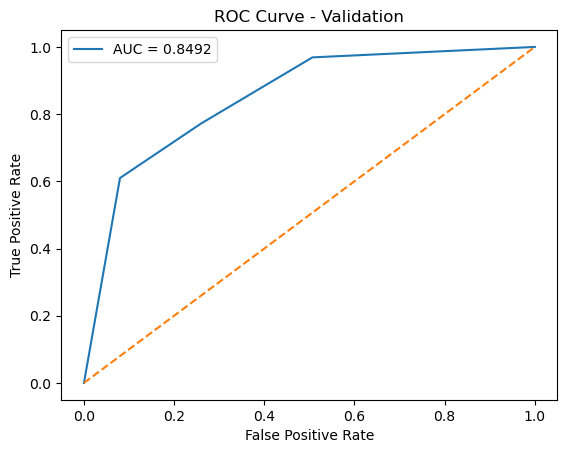

0.8492012483709446

In [120]:
compute_auroc_and_build_roc(
    limited_tree_depth_model,
    X_validation,
    y_validation,
    name="Validation"
)

AUROC for Validation: 0.8530


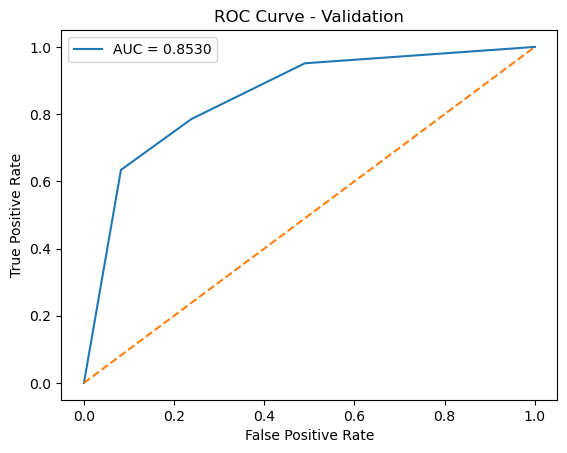

0.8530416009229569

In [121]:
compute_auroc_and_build_roc(
    limited_tree_depth_model,
    X_train,
    y_train,
    name="Validation"
)

**Завдання 3**. Спробуйте знайти такі параметри моделі `DecisionTree` аби модель генералізувала ліпше (був вищий показник AUROC на валідаційній вибірці). Проекспериментуйте з різними значеннями параметрів `max_leaf_nodes`, `max_depth` та лишіть ті, які дають найкращий результат, разом з відповідними AUROC на тренувальній і валідаційній вибірках.

В цьому завданні спробуйте просто знайти параметри методом "тика" :)

In [122]:
# model
model_1 = tree.DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5, max_leaf_nodes=2)
model_1.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",2
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node,

AUROC for Advanced Model (Validation): 0.7561


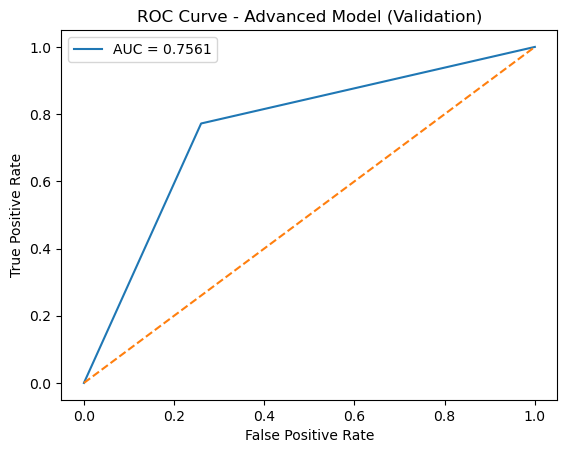

0.7561492557788599

In [123]:
# AUC ROC
compute_auroc_and_build_roc(
    model_1,
    X_validation,
    y_validation,
    name="Advanced Model (Validation)"
)

In [124]:
model_2 = tree.DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=9, max_leaf_nodes=20)
model_2.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",9
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",20
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node

AUROC for Advanced Model (Validation): 0.9211


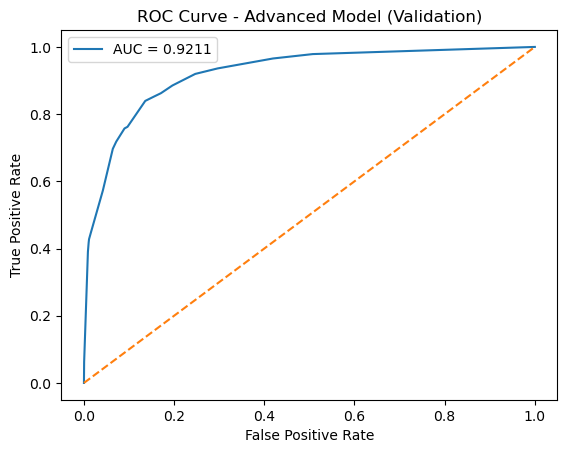

0.9211228479319569

In [125]:
# AUC ROC
compute_auroc_and_build_roc(
    model_2,
    X_validation,
    y_validation,
    name="Advanced Model (Validation)"
)

**Завдання 4**. В циклі пройдіться по значенням max_depth від 1 до 20 включно, на кожній ітерації натренуйте DecisionTree модель і виміряйте AUROC на трейн і валідаційних даних.

В кінці виведіть на графік залеєність між AUROC на трейн і валідаційних даних і номером ітерації.

In [126]:
errors_df = pd.DataFrame([
    max_depth_error(md, X_train, y_train, X_validation, y_validation)
    for md in range(1, 21)
])


In [127]:
errors_df.style.background_gradient(
    subset='Validation Error',
    cmap='Reds_r'
)

,Max Depth,Training Error,Validation Error
0,1,0.160417,0.177333
1,2,0.134250,0.139000
2,3,0.118500,0.125333
3,4,0.112750,0.118000
4,5,0.104750,0.112667
5,6,0.095917,0.109000
6,7,0.092250,0.110333
7,8,0.081833,0.109333
8,9,0.073667,0.114667
9,10,0.064167,0.117333


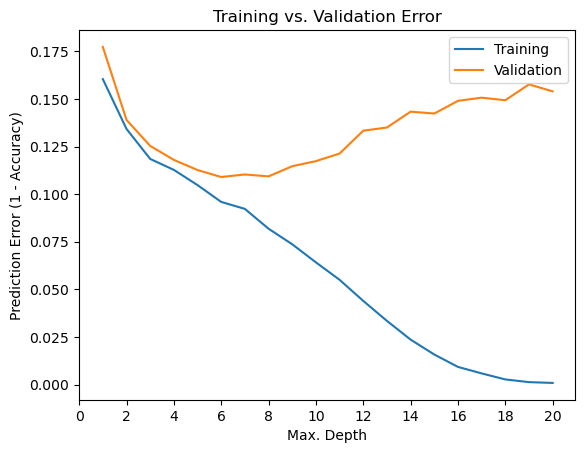

In [49]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

In [128]:
""" SNIPPET CODE 
dt_classifier = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

"""

advanced_model = tree.DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=9, max_leaf_nodes=20)

In [129]:
advanced_model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",9
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",20
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node

AUROC for Advanced Model (Validation): 0.9211


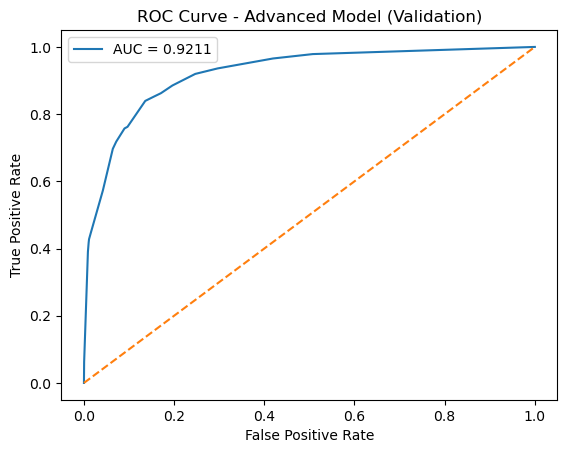

0.9211228479319569

In [130]:
compute_auroc_and_build_roc(
    advanced_model,
    X_validation,
    y_validation,
    name="Advanced Model (Validation)"
)

AUROC for Advanced Model (Training): 0.9211


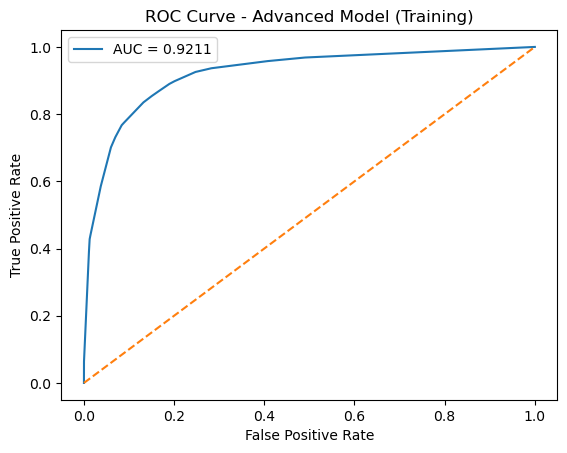

0.921086790437073

In [131]:
compute_auroc_and_build_roc(
    advanced_model,
    X_train,
    y_train,
    name="Advanced Model (Training)"
)

**Завдання 5**.
1. Натренуйте модель `DecisionTree` з найкращим значенням `max_depth`, яке ви знайшли на попередній ітерації.
2. Завантажте тестові дані змагання з `test.csv`.
3. Зробіть попередню обробку даних з функцією `preprocess_new_data` з вашого модуля `process_bank_churn.py`.
4. Зробіть передбачення використовуючи цю модель на тестових даних змагання.
5. Сформуйте `submission.csv`.
6. Зробіть новий Submission на Kaggle і додайте тут скріншот Вашого скору на паблік лідерборді :)


In [132]:
# Task 5.1 : refer to classifiers.py
advanced_model = final_decision_tree_model(X_train, y_train)

In [133]:
# Task 5.2: load the test data, done earlier
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [ ]:
"""
If functions are not being imported even after you imported -> reload the module
import importlib
from bank_chunk_data_processing import *
importlib.reload()
"""

In [157]:
# Task 5.3: preprocess the test data
X_test = preprocess_test_data(test_df, scaler=scaler, encoder=encoder, input_features=input_features)

In [158]:
# Task 5.4: make predictions on test data
test_probabilities = advanced_model.predict_proba(X_test)[:, 1]
test_predictions  = advanced_model.predict(X_test)

In [160]:
# Task 5.5: create submission.csv: ids, target.
submission = pd.DataFrame({"id": test_df["id"], "Exited": test_predictions})

submission.to_csv("submission.csv", index=False)